# Multinomial Logistic Regression

[EXPLANATION OF WHY WE CAN'T USE LINEAR REGRESSION]

[EXPLANATION OF THE FORM OF THE GENERALIZED LINEAR MODEL, E.G. WE FIND A LINK FUNCTION THAT TRANSFORMS THE MEAN OF THE OUTCOME SO THAT WE CAN USE A LINEAR EQUATION TO MODEL HOW THE MEAN CHANGES AS A FUNCTION OF THE PREDICTOR]

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# religion names from https://www.fantasynamegenerators.com/religion-names.php

np.random.seed(1000)

pop_size = 100

view = np.array(['low_tax', 'medium_tax', 'high_tax'])

income = np.random.gamma(1, size = pop_size) * 100

views = np.array([])

for inc in income:
    
    if inc < np.median(income):
        
        views = np.append(views, np.random.choice(view , 
                                                       p = [0.5/6, 2/6, 3.5/6]))
        
    elif inc >= np.median(income):
        
        views = np.append(views, np.random.choice(view , 
                                                       p = [3.5/6, 2.4/6, 0.1/6]))
        
        
df = pd.DataFrame({'income': income.astype('int'), 'tax_view': views})

df

[SHOW WHY WE DON'T USE LINEAR REGRESSION AS PER TEXTBOOK PAGE WITH MATTHEW]

In [2]:
df['tax_view'].unique()

array(['low_tax', 'high_tax', 'medium_tax'], dtype=object)

In [3]:
df['tax_view_dummy'] =  df['tax_view'].replace(df['tax_view'].unique(), np.arange(len(df['tax_view'].unique())))

df

,income,tax_view,tax_view_dummy
0,106,low_tax,0
1,12,high_tax,1
2,300,low_tax,0
3,65,medium_tax,2
4,205,medium_tax,2
...,...,...,...
95,107,medium_tax,2
96,106,low_tax,0
97,44,medium_tax,2
98,74,medium_tax,2


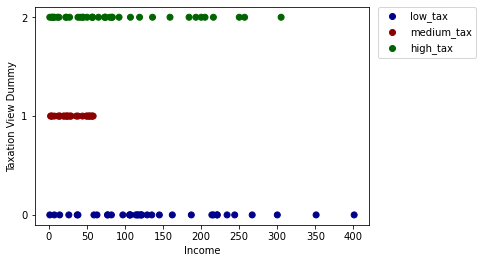

In [4]:
tax_view_color = {0: 'darkblue',
              1: 'darkred',
              2: 'darkgreen'}

fig, ax = plt.subplots()
ax.scatter(df['income'], df['tax_view_dummy'] , c = df['tax_view_dummy'].map(tax_view_color))
ax.set_yticks([0,1,2])
ax.set_ylabel('Taxation View Dummy')
ax.set_xlabel('Income')
ax.scatter([], [], color = 'darkblue', label = view[0] )
ax.scatter([], [],  color = 'darkred', label = view[1])
ax.scatter([], [],  color = 'darkgreen', label = view[2])
plt.legend(bbox_to_anchor = (1.01,1.025))
plt.show()

lin_reg = sm.OLS(df['tax_view_dummy'], sm.add_constant(df['income'])).fit()

lin_reg_predict = lin_reg.params[0] + lin_reg.params[1] * df['income']

fig, ax = plt.subplots()
ax.scatter(df['income'], df['religion_dummy'] , c = df['religion_dummy'].map(relig_color))
ax.set_yticks([0,1,2])
ax.set_ylabel('Religion Dummy')
ax.set_xlabel('Income')
ax.scatter([], [], color = 'darkblue', label = 'Children of the Titans' )
ax.scatter([], [],  color = 'darkred', label = 'Communion of the Sacrifice')
ax.scatter([], [],  color = 'darkgreen', label = 'Healers of Symmetry')
plt.scatter(df['income'], lin_reg_predict, color = 'gold', label = 'Linear Regression Predictions')
plt.legend(bbox_to_anchor = (1.01,1.025))
plt.show()

# How the model works

The abstract model:

$$
\begin{bmatrix}
           {\hat{y_{j0}}} \\
           {\hat{y_{j1}}} \\
            {\hat{y_{j2}}}  \\
           \vdots \\
           { {\hat{y_{jn}}} }
         \end{bmatrix} =
\begin{bmatrix}
           {\text{predicted log odds of being in category } j \text{ for person 0}} \\
           {\text{predicted log odds of being in category } j \text{ for person 1}} \\
           {\text{predicted log odds of being in category } j \text{  for person 2}} \\
           \vdots \\
           {\text{predicted log odds of being in category } j \text{  for person } n}
         \end{bmatrix} = b^{j}_{0} + b^{j}_{1} *\begin{bmatrix}
           {\text{income of person 0}} \\
           {\text{income of person 1}} \\
           {\text{income of person 2 }} \\
           \vdots \\
           {\text{income of person } n }
         \end{bmatrix}
$$

$  \hat{y}_{ji} = \ln\left(\frac{\text{Pr(being part of category} j)}{\text{Pr(being part of the reference category}j^{*})}\right)_{i} = b^{j}_{0} + b^{j}_{1} * \text{income}_{i}$


In our current example, using 'Children of the Titans' as the reference category:

$ \hat{y}^{\text{communion}}_{i} = \ln\left(\frac{\text{Pr(being part of Communion of the Sacrifice)}}{\text{Pr(being part of Children of the Titans)}}\right)_{i} = b_{0}^{communion} + b^{communion}_{1} * \text{income}_{i}$


$ \hat{y}^{\text{healers}}_{i} =\ln\left(\frac{\text{Pr(being part of Healers of Symmetry)}}{\text{Pr(being part of Children of the Titans)}}\right)_{i} = b_{0}^{healers} + b_{1}^{healers} * \text{income}_{i}$


If we exponentiate the log odds (i.e. raise them to the power of $e$) this will give us the predicted odds. Then, using the following conversion formula we can calculate the predicted probability of falling into a particular category as:

$ \pi_{ji} = \text{probability of being in category}j \text{ for person }i = \frac{\text{odds of being in category}j\text{ for person }i}{1 + \sum{\text{odds of being in all categories apart from the reference category for person }i}} = \frac{e^{\hat{y_{ji}}}}{1 + \sum{e^{\hat{y_{ji}}}}}$


To get the parameters we need to create indicator variables for each level of the outcome variable:

In [5]:
low_dummy = df['tax_view_dummy'] <= 0
medium_dummy = df['tax_view_dummy'] <= 1

We then find the parameters which give the maximum value of:

$ {\operatorname{arg max}} \prod \pi_{0i}^{\text{indicator}_{0i}} \pi_{1i}^{\text{indicator}_{1i}} ...\pi_{ji}^{\text{indicator}_{ji}} $

The above equation is hard for a computer to deal with. Essentially, it is multiplying fractions by fractions, over and over, which results in very small numbers. These can get so small that they get hard for a computer to represent.

To solve this problem, most software - instead of *maximizing the likelihood* - in fact *minimizes the negative log-likeihood*. The negative log-likehood function for the multinomial logistic regression model is:

$ {\operatorname{arg min}} \sum \text{indicator}_{0i} * \hat{y_{0i}} + ... \text{indicator}_{ji} * \hat{y_{ji}}  - \ln(1 + \sum{e^{\hat{y_{ji}}}})$

# The whole model

All predicted odds are relative to the reference category $j^{*}$. [Explain this, e.g. if there are three categories and the first is the reference...]

$$
\begin{bmatrix}
           {\hat{y_{j0}}} \\
           {\hat{y_{j1}}} \\
            {\hat{y_{j2}}}  \\
           \vdots \\
           { {\hat{y_{jn}}} }
         \end{bmatrix} =
\begin{bmatrix}
           {\text{predicted log odds of being in category } j \text{ for person 0}} \\
           {\text{predicted log odds of being in category } j \text{ for person 1}} \\
           {\text{predicted log odds of being in category } j \text{  for person 2}} \\
           \vdots \\
           {\text{predicted log odds of being in category } j \text{  for person } n}
         \end{bmatrix} = b^{j}_{0} + b^{j}_{1} *\begin{bmatrix}
           {\text{predictor score for person 0}} \\
           {\text{predictor score for person 1}} \\
           {\text{predictor score for person 2 }} \\
           \vdots \\
           {\text{predictor score for  person } n }
         \end{bmatrix}
$$

This can be written more compactly as (for person $i$):

$  \hat{y}_{ji} = \ln\left(\frac{\text{Pr(being part of category} j)}{\text{Pr(being part of the reference category}j^{*})}\right)_{i} = b^{j}_{0} + b^{j}_{1} * \text{predictor score}_{i}$

We can convert the predicted log odds ratios to probabilities:

$ \pi_{ji} = \text{probability of being in category}j \text{ for person }i = \frac{\text{odds of being in category}j\text{ for person }i}{1 + \sum{\text{odds of being in all categories apart from the reference category for person }i}} = \frac{e^{\hat{y_{ji}}}}{1 + \sum{e^{\hat{y_{ji}}}}}$

Conceptually, we get the maximum likelihood parameter estimates from:

$ {\operatorname{arg max}} \prod \pi_{0i}^{\text{indicator}_{0i}} \pi_{1i}^{\text{indicator}_{1i}} ...\pi_{ji}^{\text{indicator}_{ji}} $

In practice, we get the actual regression parameter estimates from:

$ {\operatorname{arg min}} \sum -\left(\text{indicator}_{ji} * \hat{y_{ji}}  - \ln(1 + \sum{e^{\hat{y_{ji}}}})\right)$



                                           

In [6]:
def pologit_cost(intercept_and_slope, x, y, y_dummies):

    intercept_1, intercept_2, slope_1, = intercept_and_slope
    
    predicted_log_odds_1 = intercept_1 + slope_1 * x
    predicted_log_odds_2 = intercept_2 + slope_1 * x
    
    p_1 = np.exp(predicted_log_odds_1)/(1 + np.exp(predicted_log_odds_1))
    
    p_2 = np.exp(predicted_log_odds_2)/(1 + np.exp(predicted_log_odds_2))
    
     
    log_likelihood = np.sum(y_dummies[0].values * np.log(p_1) + y_dummies[1].values * np.log(p_2))

    return -log_likelihood

In [7]:
pologit_cost([.1,.1,.1], df['income'], df['tax_view_dummy'], [low_dummy, medium_dummy])

5.876013590976172

In [8]:
from scipy.optimize import minimize

minimize(pologit_cost, [.1,.1,.1], args =( df['income'], df['tax_view_dummy'], [low_dummy, medium_dummy]), tol = 1e-16)

      fun: 3.970185963158787e-09
 hess_inv: array([[ 1.69471730e+08,  1.91213733e+08, -5.39508598e+06],
       [ 1.91213733e+08,  2.15745081e+08, -6.08723676e+06],
       [-5.39508598e+06, -6.08723676e+06,  1.71751106e+05]])
      jac: array([ 0.0000000e+00,  0.0000000e+00, -7.4505806e-09])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 427
      nit: 28
     njev: 83
   status: 2
  success: False
        x: array([19.04086622, 21.68708238,  0.49872827])

In [11]:
import rpy2

# Interpretting the coefficients

# How to plot the model predictions

In [ ]:
log_odds_predictions_1 = mod.params.loc['const', 0] +  mod.params.loc['income', 0] * df['income']
log_odds_predictions_2 = mod.params.loc['const', 1] +  mod.params.loc['income', 1] * df['income']

probability_predictions_1 = np.exp(log_odds_predictions_1)/(1 + np.exp(log_odds_predictions_1) + np.exp(log_odds_predictions_2))

probability_predictions_2 = np.exp(log_odds_predictions_2)/(1 + np.exp(log_odds_predictions_1) + np.exp(log_odds_predictions_2))

probability_predictions_0 = 1 - probability_predictions_1 - probability_predictions_2

In [ ]:
relig_color = {0: 'darkblue',
              1: 'darkred',
              2: 'darkgreen'}

fig, ax = plt.subplots(nrows =1, ncols=2, figsize = (16, 4))
ax[0].scatter(df['income'], df['religion_dummy'] , c = df['religion_dummy'].map(relig_color))
ax[0].set_yticks([0,1,2])
ax[0].set_ylabel('Religion Dummy')
ax[0].set_xlabel('Income')
ax[1].scatter(df['income'], probability_predictions_0, color = 'darkblue', label = 'Children of the Titans' )
ax[1].scatter(df['income'], probability_predictions_1, color = 'darkred', label = 'Communion of the Sacrifice')
ax[1].scatter(df['income'], probability_predictions_2, color = 'darkgreen', label = 'Healers of Symmetry')
ax[1].set_ylabel('Probability')
ax[1].set_xlabel('Income')
plt.legend(bbox_to_anchor = (0.1,-0.1))
plt.show()